# Business Problem

https://www.kaggle.com/competitions/cdshackdays4/overview

A Costa del Data é uma tradicional rede hoteleira espanhola. Ela possui hoje hotéis de 4 e 5 estrelas em todo o território nacional.

A empresa está preocupada com as suas projeções para os próximos anos, visando a recuperação financeira com o fim das restrições impostas pela pandemia de Covid-19.

Com a reabertura das fronteiras, a diminuição nas restrições de viagem e o aumento das vacinações, era esperado que o setor hoteleiro da Espanha retomasse os ganhos outrora esperados.

Na contramão desta expectativa, a Costa del Data tem visto um aumento em sua taxa de cancelamentos de reservas! A suspeita da diretoria é de que houve uma mudança no comportamento de cancelamentos por parte do consumidor após a pandemia, que ainda não foi compreendida pela rede.

Isso travou ações estratégicas críticas como a expansão da rede hoteleira, a reforma das unidades já com obras programadas, e a realização de ações de marketing direcionadas.

O seu time de cientistas de dados foi contratado, para compreender o fenômeno dos cancelamentos de reservas. Em posse dos resultados, o time de marketing tomará decisões mais assertivas, focando nos públicos com menor incidência de cancelamento, revertendo assim o cenário negativo atual.

Com base no histórico de reservas dos hóspedes, seu time deve desenvolver um modelo de previsão de cancelamentos. O modelo deve prever a variável alvo "Reserva Cancelada", retornando 1 em caso de cancelamento, e 0 em caso de não cancelamento.

Para esta competição, desconsiderem fatores recentes como: conflitos armados, aumento de preços energéticos, acordos comerciais e aprovações orçamentárias que envolvam a Espanha, Europa ou mesmo o mundo.

# Imports

In [1]:
import datetime
import inflection
import io
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import seaborn as sns
import xgboost as xgb

from boruta                  import BorutaPy
from IPython.display         import Image
from scipy                   import stats
from catboost                import CatBoostClassifier
from sklearn.ensemble        import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model    import Lasso, LinearRegression, LogisticRegression
from sklearn.metrics         import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error,f1_score
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.naive_bayes     import GaussianNB
from sklearn                 import tree
from sklearn.utils.class_weight import compute_sample_weight

from category_encoders       import CountEncoder, TargetEncoder
from imblearn.over_sampling  import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

# Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return round(np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) ),2)

# Load Data

In [3]:
df_raw = pd.read_csv('train.csv', low_memory=False)

# Data Description

In [4]:
df1 = df_raw.copy()

In [5]:
describe = df1.describe().T
describe

,count,mean,std,min,25%,50%,75%,max
id,72159.0,60093.687787,34726.028006,1.0,30013.5,60080.0,90301.0,120265.0
Meses da reserva até o check-in,72159.0,7.145928,25.852330,1.0,1.0,3.0,6.0,311.0
Número de pernoites reservadas,72159.0,15.824152,98.248479,0.0,2.0,3.0,4.0,1172.0
Número de hospedes,72156.0,14.258773,96.446167,0.0,2.0,2.0,2.0,1153.0
Reserva Cancelada,72159.0,0.370418,0.482920,0.0,0.0,0.0,1.0,1.0


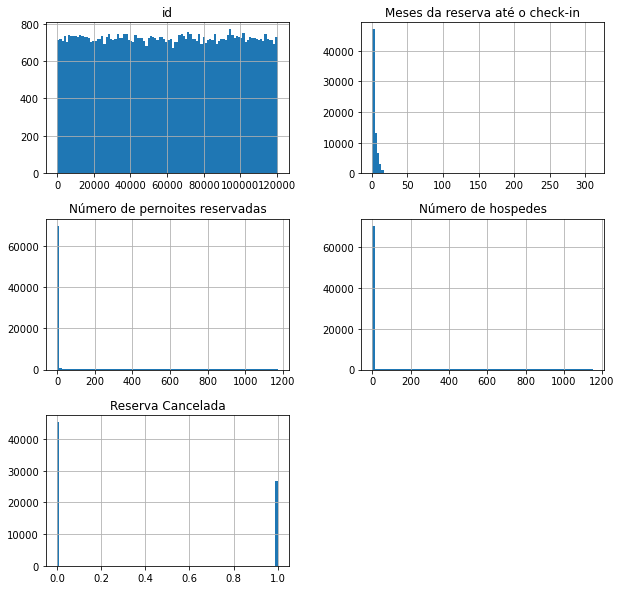

In [6]:
plt.rcParams['figure.figsize'] = [10,10]
num_attributes = df1.select_dtypes( include= ['float64', 'int64'] )
num_attributes.hist( bins= 100);

## Rename Columns

In [7]:
# Rename to snake case
cols = list(map(lambda x: inflection.transliterate(inflection.underscore(x)),
                       df1.columns))
df1.columns = [col.replace(" ","_") for col in cols]

## Data Dimension

In [8]:
print(f'Number of rows: {len(df1.index)}',
      f'\nNumber of columns: {len(df1.columns)}')

Number of rows: 72159 
Number of columns: 15


## Data types

In [9]:
df1.dtypes

id                                        int64
classificacao_do_hotel                   object
meses_da_reserva_ate_o_check_in           int64
numero_de_pernoites_reservadas            int64
numero_de_hospedes                      float64
regime_de_alimentacao                    object
nacionalidade                            object
forma_de_reserva                         object
ja_se_hospedou_anterioremente            object
tipo_do_quarto_reservado                 object
reserva_feita_por_agencia_de_turismo     object
reserva_feita_por_empresa                object
reserva_com_estacionamento               object
reserva_com_observacoes                  object
reserva_cancelada                         int64
dtype: object

## Data Head

In [10]:
df1.head()

,id,classificacao_do_hotel,meses_da_reserva_ate_o_check_in,numero_de_pernoites_reservadas,numero_de_hospedes,regime_de_alimentacao,nacionalidade,forma_de_reserva,ja_se_hospedou_anterioremente,tipo_do_quarto_reservado,reserva_feita_por_agencia_de_turismo,reserva_feita_por_empresa,reserva_com_estacionamento,reserva_com_observacoes,reserva_cancelada
0,33571,5 estrelas,5,5,2.0,Café da manha e jantar,France,Agência,Não,Amethyst,Sim,Não,Sim,Nenhuma,0
1,82458,4 estrelas,167,3,2.0,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1
2,94061,4 estrelas,4,3,2.0,Café da manha,Belgium,Agência,Não,Amethyst,Sim,Não,Não,1 a 3,0
3,75196,4 estrelas,13,2,2.0,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1
4,82940,4 estrelas,4,2,2.0,Café da manha,Spain,Agência,Não,Amethyst,Sim,Não,Não,Nenhuma,1


## Check NA

In [11]:
df1.isna().sum()

id                                         0
classificacao_do_hotel                     0
meses_da_reserva_ate_o_check_in            0
numero_de_pernoites_reservadas             0
numero_de_hospedes                         3
regime_de_alimentacao                      0
nacionalidade                           1093
forma_de_reserva                           0
ja_se_hospedou_anterioremente              0
tipo_do_quarto_reservado                   0
reserva_feita_por_agencia_de_turismo       0
reserva_feita_por_empresa                  0
reserva_com_estacionamento                 0
reserva_com_observacoes                    0
reserva_cancelada                          0
dtype: int64

## Fill and Drop NA

In [12]:
df1['nacionalidade'] = df1['nacionalidade'].apply(lambda x: 'nao_identificado' if pd.isnull(x) else x)
df1['numero_de_hospedes'] = df1['numero_de_hospedes'].apply(lambda x: 1 if pd.isnull(x) else x)

In [13]:
df1.isna().sum()

id                                      0
classificacao_do_hotel                  0
meses_da_reserva_ate_o_check_in         0
numero_de_pernoites_reservadas          0
numero_de_hospedes                      0
regime_de_alimentacao                   0
nacionalidade                           0
forma_de_reserva                        0
ja_se_hospedou_anterioremente           0
tipo_do_quarto_reservado                0
reserva_feita_por_agencia_de_turismo    0
reserva_feita_por_empresa               0
reserva_com_estacionamento              0
reserva_com_observacoes                 0
reserva_cancelada                       0
dtype: int64

## Change Type

In [14]:
df1['id'] = df1['id'].astype('int64')
df1['numero_de_hospedes'] = df1['numero_de_hospedes'].astype('int64')

# EDA - Exploratory Data Analysis

In [15]:
percent = df1.groupby('reserva_cancelada')['id'].count().reset_index()
percent['Percent'] = percent['id']/df1.shape[0]
percent.rename(columns={'id':'Total'},inplace=True)
percent

,reserva_cancelada,Total,Percent
0,0,45430,0.629582
1,1,26729,0.370418


## Multivariate Analysis

### Numerical Variables

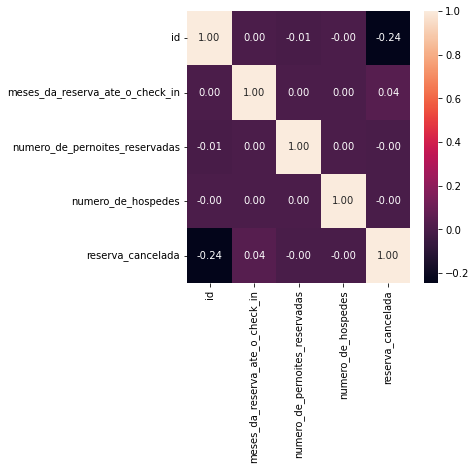

In [16]:
plt.rcParams['figure.figsize'] = [5,5]
num_attributes = df1.select_dtypes(include=['int64' , 'float64'])
corr = num_attributes.corr(method = 'pearson')
sns.heatmap(corr, annot = True, fmt='.2f');

### Categorical Variables

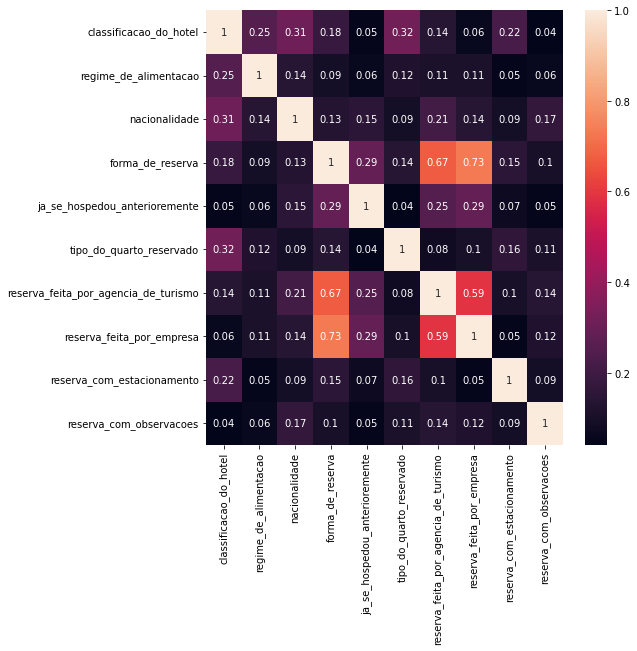

In [17]:
plt.rcParams['figure.figsize'] = [8,8]
cat_attributes = df1.select_dtypes(include='object')
lista=[]
for col in cat_attributes.columns:
    lista2 =[]
    for col2 in cat_attributes.columns:
        lista2.append(cramer_v(cat_attributes[col], cat_attributes[col2]))
    lista.append(lista2)
cramer = pd.DataFrame(lista,columns=cat_attributes.columns,index=cat_attributes.columns)
sns.heatmap(cramer,annot=True);

# Data Preparation

In [18]:
df5 = df1.copy()

## Rescaling

In [19]:
rs = RobustScaler()

# meses_da_reserva_ate_o_check-in - Robust Scaler
df5['id'] = rs.fit_transform( df5[['id']].values )

# meses_da_reserva_ate_o_check-in - Robust Scaler
df5['meses_da_reserva_ate_o_check_in'] = rs.fit_transform( df5[['meses_da_reserva_ate_o_check_in']].values )

# numero_de_pernoites_reservadas - Robust Scaler
df5['numero_de_pernoites_reservadas'] = rs.fit_transform( df5[['numero_de_pernoites_reservadas']].values )

# numero_de_hospedes - Robust Scaler
df5['numero_de_hospedes'] = rs.fit_transform( df5[['numero_de_hospedes']].values )

## Transformation

In [20]:
# Label Encoder
le = LabelEncoder()
label_cols = ['regime_de_alimentacao', 'nacionalidade', 'forma_de_reserva',
              'tipo_do_quarto_reservado','reserva_com_observacoes']
for col in label_cols:
    df5[col] = le.fit_transform(df5[col])

# Ordinal Encoding
classificacao_dict = {'5 estrelas':5, '4 estrelas':4}
df5['classificacao_do_hotel'] = df5['classificacao_do_hotel'].map(classificacao_dict)

# Boolean
bool_cols = ['ja_se_hospedou_anterioremente', 'reserva_feita_por_agencia_de_turismo',
             'reserva_feita_por_empresa', 'reserva_com_estacionamento']
for col in bool_cols:
    df5[col] = df5[col].apply(lambda x: 0 if x == 'Não' else 1 if x == 'Sim' else x)

# Feature Selection

In [21]:
df6 = df5.copy()

## Split Train Test Dataset

In [22]:
X = df6.drop(columns=['reserva_cancelada'])
y = df6[['reserva_cancelada']]

In [23]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [24]:
# criar objeto RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# realizar o upsampling na base de treino
X_train, y_train = oversampler.fit_resample( X_train, y_train )

## Boruta as Feature Selector

In [25]:
# define RandomForestRegressor
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# define Boruta
boruta = BorutaPy(clf, n_estimators='auto',verbose=2,random_state=0).fit(X_train.values, y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	7
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	7
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	7
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	7
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	8


BorutaPy finished running.

Iteration: 	13 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	8


## Best Features from Boruta

In [26]:
cols_selected_boruta = boruta.support_.tolist()
cols_selected_boruta = X_train.iloc[:,cols_selected_boruta].columns.tolist()

## Manual Features

In [27]:
cols_selected_boruta

['id',
 'classificacao_do_hotel',
 'meses_da_reserva_ate_o_check_in',
 'nacionalidade',
 'reserva_com_estacionamento',
 'reserva_com_observacoes']

In [28]:
#cols_selected_boruta = ['id',
#                        'classificacao_do_hotel',
#                        'meses_da_reserva_ate_o_check_in',
#                        'nacionalidade',
#                        'reserva_com_estacionamento',
#                        'reserva_com_observacoes']

# Machine Learning Modelling

In [29]:
#x_train = X_train[cols_selected_boruta]
#x_test  = X_test[cols_selected_boruta]

x_train = X_train.copy()
x_test  = X_test.copy()

## KNN

In [30]:
# model definition
result_list = []

# Choose k number
for k in range(3, 15):

    knn_model = KNeighborsClassifier( n_neighbors= k )

    # model training
    knn_model.fit( x_train, y_train )

    # model classifier
    y_pred = knn_model.predict( x_test )
    
    # performance
    f_score_knn = f1_score( y_test, y_pred, average= 'macro')
    
    result_list.append( {"k":k,"f_score":f_score_knn} )
    
# K with highest score
k = max(result_list, key=lambda x: x['f_score'])['k']
f_score_knn = max(result_list, key=lambda x: x['f_score'])['f_score']
print(f"K = {k}\nF-Score = {f_score_knn:.2%}")

K = 4
F-Score = 85.46%


## Logistic Regression

In [31]:
# model definition
lr_model = LogisticRegression()

# model training
lr_model.fit( x_train, y_train )

# model classifier
y_pred_lr = lr_model.predict(x_test)

In [32]:
# performance
f_score_lr = f1_score( y_test, y_pred_lr, average= 'macro')
print( f'F-score knn: {f_score_lr:.2%}' )

F-score knn: 72.81%


## Random Forest

In [33]:
# model definition
rf_model = RandomForestClassifier( n_estimators=100, n_jobs=-1, random_state= 42)

# model training
rf_model.fit( x_train, y_train )

# model classifier
y_pred_rf = rf_model.predict(x_test)

In [34]:
# performance
f_score_rf = f1_score( y_test, y_pred_rf, average= 'macro')

print( f'F-score Random Forest: {f_score_rf:.2%}' )

F-score Random Forest: 96.76%


## XGBoost

In [35]:
# model definition
xgb_model = GradientBoostingClassifier( n_estimators= 1500, max_depth=10, subsample= 0.8)

# model training
xgb_model.fit( x_train, y_train )

# model classifier
y_pred_xgb = xgb_model.predict(x_test)

In [36]:
# performance
f_score_xgb = f1_score( y_test, y_pred_xgb, average= 'macro')

print( f'F-score XGBoost: {f_score_xgb:.2%}' )

F-score XGBoost: 96.86%


## Categorical Boost (Cat Boost)

In [37]:
# model definition
cat_model = CatBoostClassifier( iterations = 1000, learning_rate= 0.2)

# model training
cat_model.fit( x_train, y_train, verbose = False)


# model classifier
y_pred_cat = cat_model.predict(x_test)

In [38]:
# performance
f_score_cat = f1_score( y_test, y_pred_cat, average= 'macro')

print( f'F-score CatBoost: {f_score_cat:.2%}' )

F-score CatBoost: 96.52%


## Naive Bayes

In [39]:
# model definition
nb_model = GaussianNB()

# model training
nb_model.fit( x_train, y_train)

# model classifier
y_pred_nb = nb_model.predict(x_test)

In [40]:
# performance
f_score_nb = f1_score( y_test, y_pred_nb, average= 'macro')

print( f'F-score Naive Bayes: {f_score_nb:.2%}' )

F-score Naive Bayes: 48.12%


## Decision Tree

In [41]:
# Crie uma instância do classificador de árvore de decisão
clf = tree.DecisionTreeClassifier()

# Treine o classificador usando os dados de treinamento
clf.fit(x_train, y_train)

# Faça previsões usando o conjunto de teste
y_pred_clf = clf.predict(x_test)

In [42]:
# performance
f_score_clf = f1_score( y_test, y_pred_clf, average= 'macro')

print( f'F-score Decision Tree: {f_score_clf:.2%}' )

F-score Decision Tree: 96.19%


# XGBoost Hyperparameter Fine Tuning

In [43]:
t_start = time.time()
print('Start:',datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))

Start: 29-03-2023 21:33:36


In [44]:
param = {'learning_rate': [0.01, 0.05, 0.1, 0.2],
         'max_depth': [3, 4, 5, 10],
         'n_estimators': [100, 500, 1000, 1500],
         'subsample':[0.1,0.3,0.8,1.0]}
# Calculate weights

# y array of weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y)

# dict of weights
n_classes = len(np.unique(y))
weight_0  = len(y) / (n_classes * y.value_counts()[0])
weight_1  = len(y) / (n_classes * y.value_counts()[1])
class_weights = {0:weight_0,1:weight_1}

# use RandomizedSearchCV to find the best hyperparameter combination.
random_search = RandomizedSearchCV(GradientBoostingClassifier(),
                                   param_distributions=param,
                                   cv=5,
                                   n_iter=30,
                                   scoring='f1_macro',
                                   random_state=42,
                                   n_jobs=-1)
random_search.fit(X.values, y.values, sample_weight=sample_weights)

# print the best hyperparameter combination and its F-score (macro).
print("Best hyperparameter:", random_search.best_params_)
print(f"Best F-score (macro): {random_search.best_score_:.2%}")

Best hyperparameter: {'subsample': 0.3, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.05}
Best F-score (macro): 97.05%


In [45]:
duration = time.time()-t_start
h = '{:02d}'.format(int(duration//3600))
m = '{:02d}'.format(int((duration%3600)//60))
s = '{:02d}'.format(int(duration%60))

print('End:',datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))
print(f'Fine tuning execution time: {h}:{m}:{s}')

End: 29-03-2023 23:38:42
Fine tuning execution time: 02:05:05


# Final Model

In [46]:
param = random_search.best_params_

# model definition
xgb_model = GradientBoostingClassifier(subsample     = param['subsample'],
                                       n_estimators  = param['n_estimators'],
                                       max_depth     = param['max_depth'],
                                       learning_rate = param['learning_rate'],
                                       random_state=42)

# model training
xgb_model.fit(X.values, y.values, sample_weight=sample_weights)
#xgb_model.fit( x_train, y_train )

GradientBoostingClassifier(learning_rate=0.05, max_depth=10, n_estimators=500,
                           random_state=42, subsample=0.3)

# Predict Kaggle Submission Data

In [47]:
test   = pd.read_csv('test.csv', low_memory=False)
_id = test['id']

## Rename Columns

In [48]:
# Rename to snake case
cols = list(map(lambda x: inflection.transliterate(inflection.underscore(x)),
                       test.columns))
test.columns = [col.replace(" ","_") for col in cols]

## Fill NA

In [49]:
test['nacionalidade']      = test['nacionalidade'].apply(lambda x: 'nao_identificado' if pd.isnull(x) else x)
test['numero_de_hospedes'] = test['numero_de_hospedes'].apply(lambda x: 1 if pd.isnull(x) else x)
test['numero_de_hospedes'] = test['numero_de_hospedes'].astype('int64')

## Change type

In [50]:
test['id'] = test['id'].astype('int64')
test['numero_de_hospedes'] = test['numero_de_hospedes'].astype('int64')

## Rescaling

In [51]:
rs = RobustScaler()

# meses_da_reserva_ate_o_check-in - Robust Scaler
test['id'] = rs.fit_transform( test[['id']].values )

# meses_da_reserva_ate_o_check-in - Robust Scaler
test['meses_da_reserva_ate_o_check_in'] = rs.fit_transform( test[['meses_da_reserva_ate_o_check_in']].values )

# numero_de_pernoites_reservadas - Robust Scaler
test['numero_de_pernoites_reservadas'] = rs.fit_transform( test[['numero_de_pernoites_reservadas']].values )

# numero_de_hospedes - Robust Scaler
test['numero_de_hospedes'] = rs.fit_transform( test[['numero_de_hospedes']].values )

## Transformation

In [52]:
# Label Encoder
le = LabelEncoder()
label_cols = ['regime_de_alimentacao', 'nacionalidade', 'forma_de_reserva',
              'tipo_do_quarto_reservado','reserva_com_observacoes']
for col in label_cols:
    test[col] = le.fit_transform(test[col])

# Ordinal Encoding
classificacao_dict = {'5 estrelas':5, '4 estrelas':4}
test['classificacao_do_hotel'] = test['classificacao_do_hotel'].map(classificacao_dict)

# Boolean
bool_cols = ['ja_se_hospedou_anterioremente', 'reserva_feita_por_agencia_de_turismo',
             'reserva_feita_por_empresa', 'reserva_com_estacionamento']
for col in bool_cols:
    test[col] = test[col].apply(lambda x: 0 if x == 'Não' else 1 if x == 'Sim' else x)

## Predict

In [53]:
y_pred_test = xgb_model.predict(test.values)
submission = pd.concat([_id, pd.Series(y_pred_test, name = 'Reserva Cancelada')], axis=1)

## Create submission file

In [54]:
submission.to_csv('submission.csv', index=False )

In [55]:
percent2 = submission.groupby('Reserva Cancelada')['id'].count().reset_index()
percent2['Percent'] = percent2['id']/submission.shape[0]
percent2.rename(columns={'id':'Total'},inplace=True)
percent2

,Reserva Cancelada,Total,Percent
0,0,33065,0.687336
1,1,15041,0.312664
